Importing Libraries & Defining Functions

In [8]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import IsolationForest
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from numpy.fft import fft, fftfreq
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np
from sklearn.ensemble import (
    RandomForestRegressor,
    HistGradientBoostingRegressor,
    RandomForestClassifier
)
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    confusion_matrix,
    accuracy_score,
    f1_score,
    classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split

In [9]:
def csv_to_df_concatenator(list_of_paths, axis=None, **kwargs):
    '''
    given a list of paths, it will load all those CSV files and concatenate them 
    based on column names and axis if given 0 or 1.
    kwargs may also be passed to use when reading the files.
    '''
    output_dfs = []
    for csv_file in list_of_paths:
        small_df = pd.read_csv(csv_file, **kwargs)
        output_dfs.append(small_df)
    if axis is not None:
        return pd.concat(output_dfs, axis=axis)
    else:
        return pd.concat(output_dfs)
    
def normalize_segments(df, indices, cols_ignore=[]):
    df_ignore = df[cols_ignore]
    time_col = df['TimeStr']
    df = df[["34-2-V-O-O", "35-3-V-O-B", "38-6-WIS-O", "39-7-WIS-B", 
          "36-4-V-B-O", "37-5-V-B-B", "40-8-OMG", "33-1-Olie"]]
    out = []
    time_out = []
    ignore_out = []
    for start, end in zip(indices[:-1], indices[1:]):
        seg = df.iloc[start:end].copy()
        ignore_out_seg = df_ignore.iloc[start:end].copy()
        time_col_seg = time_col.iloc[start:end].copy()
        seg = (seg - seg.mean()) / seg.std()
        out.append(seg)
        time_out.append(time_col_seg)
        ignore_out.append(ignore_out_seg)
    return pd.concat(out), pd.concat(time_out), pd.concat(ignore_out)

def assign_machine_runs(df, gap_indices):

    # copy so you don't mutate original
    df_out = df.copy()
    
    gap_indices = sorted(gap_indices)
    run_labels = [0] * len(df_out)

    # define start/end for each segment
    for i in range(len(gap_indices)):
        start = gap_indices[i] + 1
        
        if i + 1 < len(gap_indices):
            end = gap_indices[i+1]
        else:
            end = len(df_out)

        # all rows in this segment get run number (1-indexed)
        for idx in range(start, end):
            run_labels[idx] = i + 1

    df_out["machine_run"] = run_labels
    return df_out

def collect_confusion(results_dict):
    cms = {}
    for run_id, models in results_dict.items():
        for model, metrics in models.items():
            if 'confusion_matrix' in metrics:
                cms.setdefault(model, []).append(metrics['confusion_matrix'])
    return cms

def train_regression(X, y, model, TEST_SIZE, RANDOM_STATE):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    model.fit(X_tr, y_tr)
    return {
        'train_R2': r2_score(y_tr, model.predict(X_tr)),
        'train_MSE': mean_squared_error(y_tr, model.predict(X_tr)),
        'test_R2': r2_score(y_te, model.predict(X_te)),
        'test_MSE': mean_squared_error(y_te, model.predict(X_te))
    }, model

def train_classifier(X, y, model, TEST_SIZE, RANDOM_STATE):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    return {
        'accuracy': accuracy_score(y_te, y_pred),
        'f1': f1_score(y_te, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_te, y_pred),
        'classification_report': classification_report(
            y_te, y_pred, output_dict=True, zero_division=0
        )
    }, model

def get_top_features(model, feature_names, top_n):
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
    elif hasattr(model, 'coef_'):
        imp = np.abs(model.coef_).flatten()
    else:
        return []
    return (
        pd.DataFrame({'feature': feature_names, 'importance': imp})
        .sort_values('importance', ascending=False)
        .head(top_n)['feature']
        .tolist()
    )

def make_pca(X, PCA_VARIANCE, RANDOM_STATE):
    X_scaled = StandardScaler().fit_transform(X)
    return PCA(n_components=PCA_VARIANCE, random_state=RANDOM_STATE).fit_transform(X_scaled)

def crossfold_regression(X, y, model, N_SPLITS, RANDOM_STATE):
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    r2s, mses = [], []

    for tr_idx, te_idx in kf.split(X):
        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        r2s.append(r2_score(y_te, y_pred))
        mses.append(mean_squared_error(y_te, y_pred))

    return {
        'crossfold_R2': np.mean(r2s),
        'crossfold_MSE': np.mean(mses)
    }

def make_df(results_dict):
    rows = []
    for run_id, models in results_dict.items():
        for model, metrics in models.items():
            rows.append({'run': run_id, 'model': model, **metrics})
    return pd.DataFrame(rows)

def save_dfs_to_excel(dfs_dict, filename):
    with pd.ExcelWriter(filename) as writer:
        for target, df in dfs_dict.items():
            # Replace any invalid sheet name characters
            sheet_name = target[:31]  # Excel sheet name limit
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    print(f"Saved {filename} successfully!")

Loading Dataset and Concatenating

In [10]:
AERO_csv_files = glob.glob(os.path.join('AERO', "*.csv"))

In [11]:
aero_df = csv_to_df_concatenator(AERO_csv_files, axis=0, sep=";", low_memory=False)

In [12]:
aero_df = aero_df.replace(["Undef", np.nan, None], np.nan)
aero_df['TimeStr'] = pd.to_datetime(aero_df['TimeStr'], errors='coerce')
aero_df = aero_df.sort_values('TimeStr')
temp_columns = ['33-1-Olie', '34-2-V-O-O','35-3-V-O-B', '36-4-V-B-O', 
                '37-5-V-B-B', '38-6-WIS-O', '39-7-WIS-B','40-8-OMG']
machine_columns = ['StangData.L_e_Set', 'StangData.L_v_Set', 'StangData.La_v',
       'StangData.La_v_offset', 'StangData.Oa_v', 'StangData.VU_centre',
       'StangData.d_vert', 'StangData.da_Vert', 'StangData.da_Vert_offset',
       'StangHistorie[1].Goedgekeurd', 'StangHistorie[1].L_e',
       'StangHistorie[1].L_v', 'StangHistorie[1].b_gem',
       'StangHistorie[1].d_gem', 'UserVarGlobal.AantalSpaken',
       'UserVarGlobal.stangenteller_1', 'UserVarGlobal.stangenteller_2']

aero_df[temp_columns] = aero_df[temp_columns].astype(float)
aero_df = aero_df.dropna()
aero_df = aero_df.reset_index(drop=True)

Creating Gap Indices to detect machine runs.

In [13]:
threshold = pd.Timedelta(seconds=11)

gaps = []
for i in range(1, len(aero_df)):
    gap_length = aero_df['TimeStr'].iloc[i] - aero_df['TimeStr'].iloc[i-1]
    if gap_length > threshold:
        gaps.append({
            "gap_index": i,
            "gap_length": gap_length,
            "gap_start": aero_df['TimeStr'].iloc[i-1],
            "gap_end": aero_df['TimeStr'].iloc[i]
        })

gaps_df = pd.DataFrame(gaps)
gap_indices = gaps_df['gap_index'].tolist()

Cleaning

In [14]:
temps_df = aero_df[['TimeStr'] + temp_columns]

In [15]:
renamed_machine_columns = ['L_e_Set', 'L_v_Set', 'La_v',
 'La_v_offset', 'Oa_v', 'VU_centre',
 'd_vert', 'da_Vert', 'da_Vert_offset',
 'target_Goedgekeurd', 'target_L_e',
 'target_L_v', 'target_b_gem',
 'target_d_gem', 'AantalSpaken',
 'stangenteller_1', 'stangenteller_2']

'''
4, 5, 6, 7, 8, 14, 15, 16 are constant
col 13 is variable <- Continuous Target (dgem)
col 12 is variable <- Continuous Target (bgem)
col 11 is variable <- Continuous Target (L_v)
col 10 is variable <- Continuous Target (L_e)
col 9 has 2 variations <- Binary Target (Accepted or Rejected)
col 3 has 5 variations
col 2 has 14 variations
col 1 has 11 variations <- Same variations as col 2 (L_v_Set, La_v).
col 0 has 2 variations
'''

machine_params_df = aero_df[['TimeStr'] + machine_columns]
machine_params_df.columns = ['TimeStr'] + renamed_machine_columns
machine_params_df = machine_params_df.drop(columns=
                                           np.array(renamed_machine_columns)[[4, 5, 6, 7, 8, 14, 15, 16]])

In [16]:
new_machine_cols = list(machine_params_df.columns)[1:]
machine_params_df[new_machine_cols] = machine_params_df[new_machine_cols].astype(float)
new_aero_df = pd.concat([temps_df, machine_params_df[new_machine_cols]],axis=1)

Window Slicing (Creation of AERO small)

In [17]:
aero_small = []

gap_indices = gaps_df['gap_index'].tolist()
boundaries = [0] + gap_indices + [len(new_aero_df)]

In [18]:
for run_id in range(len(boundaries)-1):
    
    start_ind = boundaries[run_id]
    end_ind   = boundaries[run_id+1]

    # normalization
    norm_df, time_col, mach_params_df = normalize_segments(
        new_aero_df,
        [start_ind, end_ind],
        cols_ignore=new_machine_cols
    )

    # add time as column
    norm_df = norm_df.copy()
    norm_df["TimeStr"] = time_col
    mach_params_df["TimeStr"] = time_col

    # group both dataframes on the same time windows
    grouped_norm = norm_df.groupby(pd.Grouper(key="TimeStr", freq="1min"))
    grouped_mach = mach_params_df.groupby(pd.Grouper(key="TimeStr", freq="1min"))

    for window_start, group_norm in grouped_norm:

        if group_norm.empty:
            continue

        # matching machine params group
        group_mach = grouped_mach.get_group(window_start) \
            if window_start in grouped_mach.groups else None

        row_features = {
            "TimeStr": window_start,
            "machine_run": run_id
        }

        #Features 
        for col in group_norm.columns.drop("TimeStr"):

            series = group_norm[col].dropna()
            if series.empty:
                continue

            mean = series.mean()
            var  = series.var()

            row_features[f"{col}_mean"]      = mean
            row_features[f"{col}_mode"]    = series.mode().iloc[0]
            row_features[f"{col}_variance"]  = var

            #Removed due to numerical instabilities.
            #row_features[f"{col}_skewness"]  = skew(series, bias=False) if var > 0 else 0.0
            #row_features[f"{col}_kurtosis"]  = kurtosis(series, bias=False) if var > 0 else 0.0

            rolling = series.rolling(3, min_periods=1)
            row_features[f"{col}_rolling_mean_3"] = rolling.mean().iloc[-1]
            row_features[f"{col}_rolling_std_3"]  = rolling.std().iloc[-1]

            row_features[f"{col}_num_peaks"] = len(find_peaks(series)[0])
            row_features[f"{col}_max_slope"] = (
                np.max(np.abs(np.diff(series))) if len(series) > 1 else 0.0
            )

            if len(series) > 1:
                diffs = np.diff(series)
                row_features[f"{col}_heating_rate_max"] = np.max(diffs)
                row_features[f"{col}_cooling_rate_max"] = np.min(diffs)
            else:
                row_features[f"{col}_heating_rate_max"] = 0.0
                row_features[f"{col}_cooling_rate_max"] = 0.0

            row_features[f"{col}_duration_above_mean"] = np.sum(series > mean)
            row_features[f"{col}_duration_below_mean"] = np.sum(series < mean)

            #spectral features
            if len(series) > 1 and series.nunique() > 1:
                fft_vals = np.abs(fft(series))
                fft_vals[0] = 0
                freqs = fftfreq(len(series), d=1)

                total_energy = np.sum(fft_vals ** 2)
                sum_fft = np.sum(fft_vals)

                row_features[f"{col}_dominant_freq"] = freqs[np.argmax(fft_vals)]
                row_features[f"{col}_spectral_energy"] = total_energy
                row_features[f"{col}_spectral_centroid"] = (
                    np.sum(freqs * fft_vals) / sum_fft if sum_fft else 0.0
                )

                fft_prob = fft_vals / sum_fft if sum_fft else np.zeros_like(fft_vals)
                row_features[f"{col}_spectral_entropy"] = -np.sum(
                    fft_prob * np.log(fft_prob + 1e-12)
                )
            else:
                row_features[f"{col}_dominant_freq"]    = 0.0
                row_features[f"{col}_spectral_energy"]   = 0.0
                row_features[f"{col}_spectral_centroid"] = 0.0
                row_features[f"{col}_spectral_entropy"]  = 0.0

        #Targets
        if group_mach is not None and not group_mach.empty:
            row_features.update({
                "L_e_Set_mode": group_mach["L_e_Set"].mode().iloc[0],
                "L_v_Set_mode": group_mach["L_v_Set"].mode().iloc[0],
                "La_v_mode": group_mach["La_v"].mode().iloc[0],
                "La_v_offset_mode": group_mach["La_v_offset"].mode().iloc[0],
                "target_Goedgekeurd_mode": group_mach["target_Goedgekeurd"].mode().iloc[0],
                "target_L_e_mean": group_mach["target_L_e"].mean(),
                "target_L_v_mean": group_mach["target_L_v"].mean(),
                "target_b_gem_mean": group_mach["target_b_gem"].mean(),
                "target_d_gem_mean": group_mach["target_d_gem"].mean(),
            })

        aero_small.append(row_features)
aero_small = pd.DataFrame(aero_small)


Visualizing and Familiarizing with AERO Small

In [19]:
features = ['_mean', '_mode', '_variance', 
            #'_skewness', '_kurtosis',
              '_rolling_mean_3',
            '_rolling_std_3', '_num_peaks', '_max_slope', 
            '_heating_rate_max', '_cooling_rate_max', '_duration_above_mean',
            '_duration_below_mean',
              '_dominant_freq', '_spectral_energy',
            '_spectral_centroid', '_spectral_entropy']

sensors = ["34-2-V-O-O", "35-3-V-O-B", "38-6-WIS-O", "39-7-WIS-B", 
           "36-4-V-B-O", "37-5-V-B-B", "40-8-OMG", "33-1-Olie"]

In [20]:
temp_vars_names = aero_small.columns[2:-9]
machine_vars_names = aero_small.columns[-9:-5]
target_names = aero_small.columns[-5:]

In [21]:
# Comment this out if you don't wnat the model to predict the next time slice, 
# but predict the current one instead.
aero_small[target_names] = aero_small[target_names].iloc[:-1,:]
aero_small = aero_small.iloc[:-1,:]

In [22]:
aero_small

,TimeStr,machine_run,34-2-V-O-O_mean,34-2-V-O-O_mode,34-2-V-O-O_variance,34-2-V-O-O_rolling_mean_3,34-2-V-O-O_rolling_std_3,34-2-V-O-O_num_peaks,34-2-V-O-O_max_slope,34-2-V-O-O_heating_rate_max,...,33-1-Olie_spectral_entropy,L_e_Set_mode,L_v_Set_mode,La_v_mode,La_v_offset_mode,target_Goedgekeurd_mode,target_L_e_mean,target_L_v_mean,target_b_gem_mean,target_d_gem_mean
0,2025-09-12 08:35:00,0,-1.557029,-1.532453,0.003763,-1.532453,0.000000,2,0.221188,0.221188,...,2.827526,22.5,236.2,236.2,-0.2,1.0,22.644900,236.872033,2.226444,1.000444
1,2025-09-12 08:36:00,0,-1.581606,-1.532453,0.004970,-1.532453,0.000000,3,0.147459,0.147459,...,3.158340,22.5,236.2,236.2,-0.2,1.0,22.750425,236.856717,2.223500,1.005167
2,2025-09-12 08:37:00,0,-1.618470,-1.679911,0.005436,-1.532453,0.000000,1,0.221188,0.221188,...,3.150835,22.5,236.2,236.2,-0.2,1.0,22.808792,236.863033,2.221583,1.002000
3,2025-09-12 08:38:00,0,-1.538597,-1.532453,0.006018,-1.679911,0.000000,3,0.221188,0.147459,...,3.262438,22.5,236.2,236.2,-0.2,1.0,22.700467,236.878683,2.223833,0.999583
4,2025-09-12 08:39:00,0,-1.532453,-1.532453,0.004659,-1.606182,0.000000,3,0.221188,0.221188,...,3.139266,22.5,236.2,236.2,-0.2,1.0,22.783817,236.939708,2.222417,0.998917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,2025-12-12 03:54:00,4,0.858656,0.720207,0.508830,0.535607,0.845941,4,2.215192,1.661394,...,2.298466,20.0,260.0,260.0,6.0,0.0,24.899700,266.195400,2.237000,0.954000
3537,2025-12-12 03:55:00,4,1.089405,1.274005,0.520448,0.535607,0.639471,3,1.661394,1.661394,...,2.370698,20.0,260.0,260.0,6.0,0.0,24.899700,266.195400,2.237000,0.954000
3538,2025-12-12 03:56:00,4,1.274005,1.274005,0.278811,1.458604,0.319735,2,1.107596,1.107596,...,2.359618,20.0,260.0,260.0,6.0,0.0,24.899700,266.195400,2.237000,0.954000
3539,2025-12-12 03:57:00,4,1.089405,0.720207,0.185874,1.643203,0.319735,2,1.107596,1.107596,...,2.165616,20.0,260.0,260.0,6.0,0.0,24.899700,266.195400,2.237000,0.954000


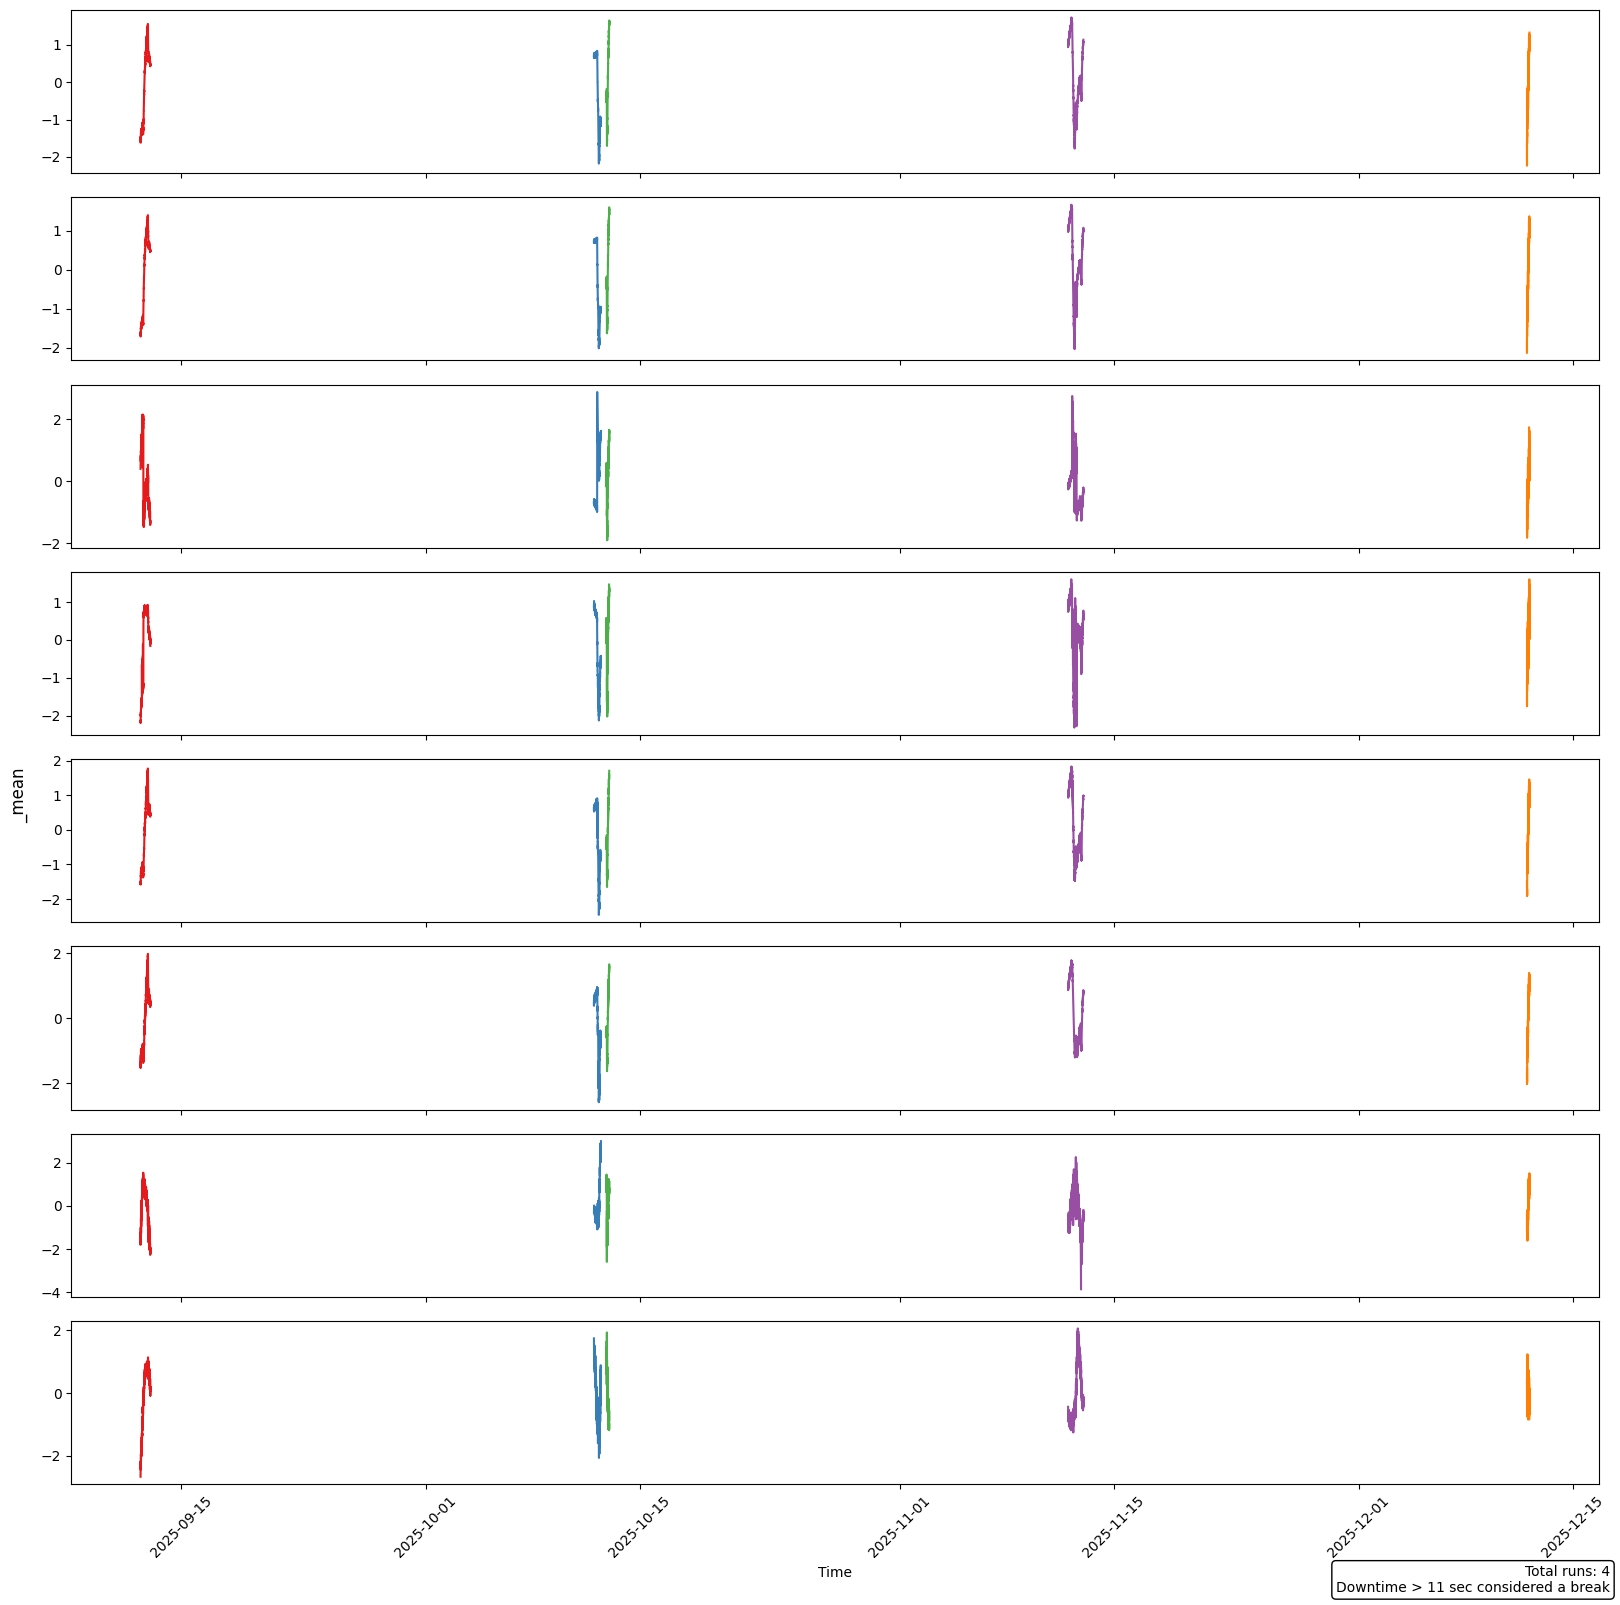

In [23]:

base_colors = [
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3",
    "#ff7f00", "#ffff33", "#a65628", "#f781bf"
]

aero_small['color'] = aero_small['machine_run'].apply(
    lambda x: base_colors[x % len(base_colors)]
)

fig, axes = plt.subplots(
    len(sensors), 1,
    figsize=(16, 2 * len(sensors)),
    sharex=True
)

for i, sensor in enumerate(sensors):
    ax = axes[i]

    # normal runs
    for run_id, group in aero_small.groupby('machine_run'):
        ax.plot(
            group['TimeStr'],
            group[f"{sensor}{features[0]}"],
            c=base_colors[run_id % len(base_colors)],
            label=f'Run {run_id}'
        )

axes[-1].set_xlabel('Time')
plt.xticks(rotation=45)

fig.text(
    -0.01, 0.5,
    f'{features[0]}',
    va='center', rotation='vertical', fontsize=12
)

fig.text(
    0.99, 0.0,
    f"Total runs: {len(gap_indices)}\nDowntime > 11 sec considered a break",
    ha="right", va="bottom",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black")
)

plt.tight_layout()
plt.show()


Preparing for Experiment-setup

In [24]:
# Dictionary to hold each machine run
df_runs = {}

for run_id in aero_small['machine_run'].unique():
    df_runs[run_id] = aero_small[aero_small['machine_run'] == run_id].copy()
print(len(df_runs.keys()))
df_run0 = df_runs[0]
df_run1 = df_runs[1]
df_run2 = df_runs[2]
df_run3 = df_runs[3]
df_run4 = df_runs[4]
print("length dfs")
print(len(df_run0),len(df_run1),len(df_run2),len(df_run3),len(df_run4),)
print("value counts")
for k,item in df_runs.items():
    for target in target_names:
        if len(item[target].unique()) <=3:
            print(f'df run {k},', f'{target},', item[target].unique())

5
length dfs
925 665 272 1440 239
value counts
df run 0, target_Goedgekeurd_mode, [1. 0.]
df run 1, target_Goedgekeurd_mode, [1. 0.]
df run 2, target_Goedgekeurd_mode, [1.]
df run 2, target_L_e_mean, [22.8002]
df run 2, target_L_v_mean, [236.8529 236.8529]
df run 2, target_b_gem_mean, [2.228 2.228]
df run 2, target_d_gem_mean, [0.996 0.996]
df run 3, target_Goedgekeurd_mode, [1. 0.]
df run 4, target_Goedgekeurd_mode, [0.]
df run 4, target_L_e_mean, [24.8997]
df run 4, target_L_v_mean, [266.1954]
df run 4, target_b_gem_mean, [2.237 2.237]
df run 4, target_d_gem_mean, [0.954]


In [25]:
#The folowing runs were excluded due small size
df_runs.pop(2)
df_runs.pop(4)

,TimeStr,machine_run,34-2-V-O-O_mean,34-2-V-O-O_mode,34-2-V-O-O_variance,34-2-V-O-O_rolling_mean_3,34-2-V-O-O_rolling_std_3,34-2-V-O-O_num_peaks,34-2-V-O-O_max_slope,34-2-V-O-O_heating_rate_max,...,L_e_Set_mode,L_v_Set_mode,La_v_mode,La_v_offset_mode,target_Goedgekeurd_mode,target_L_e_mean,target_L_v_mean,target_b_gem_mean,target_d_gem_mean,color
3302,2025-12-12 00:00:00,4,-1.679585,-1.494986,0.297399,-1.125787,0.319735,3,1.107596,1.107596,...,20.0,260.0,260.0,6.0,0.0,24.8997,266.1954,2.237,0.954,#ff7f00
3303,2025-12-12 00:01:00,4,-1.633435,-1.494986,0.285781,-1.494986,0.000000,2,1.107596,1.107596,...,20.0,260.0,260.0,6.0,0.0,24.8997,266.1954,2.237,0.954,#ff7f00
3304,2025-12-12 00:02:00,4,-1.910334,-2.602582,0.453068,-2.048784,0.959206,2,1.661394,1.661394,...,20.0,260.0,260.0,6.0,0.0,24.8997,266.1954,2.237,0.954,#ff7f00
3305,2025-12-12 00:03:00,4,-2.233383,-2.602582,0.185874,-2.602582,0.000000,3,1.107596,1.107596,...,20.0,260.0,260.0,6.0,0.0,24.8997,266.1954,2.237,0.954,#ff7f00
3306,2025-12-12 00:04:00,4,-1.818035,-1.494986,0.471656,-1.494986,0.553798,2,1.661394,1.107596,...,20.0,260.0,260.0,6.0,0.0,24.8997,266.1954,2.237,0.954,#ff7f00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,2025-12-12 03:54:00,4,0.858656,0.720207,0.508830,0.535607,0.845941,4,2.215192,1.661394,...,20.0,260.0,260.0,6.0,0.0,24.8997,266.1954,2.237,0.954,#ff7f00
3537,2025-12-12 03:55:00,4,1.089405,1.274005,0.520448,0.535607,0.639471,3,1.661394,1.661394,...,20.0,260.0,260.0,6.0,0.0,24.8997,266.1954,2.237,0.954,#ff7f00
3538,2025-12-12 03:56:00,4,1.274005,1.274005,0.278811,1.458604,0.319735,2,1.107596,1.107596,...,20.0,260.0,260.0,6.0,0.0,24.8997,266.1954,2.237,0.954,#ff7f00
3539,2025-12-12 03:57:00,4,1.089405,0.720207,0.185874,1.643203,0.319735,2,1.107596,1.107596,...,20.0,260.0,260.0,6.0,0.0,24.8997,266.1954,2.237,0.954,#ff7f00


In [26]:

targets = {
    'target_Goedgekeurd_mode': 'binary',
    'target_L_e_mean': 'regression',
    'target_L_v_mean': 'regression',
    'target_b_gem_mean': 'regression',
    'target_d_gem_mean': 'regression'
}
TEST_SIZE = 0.2
TOP_N_FEATURES = 10
PCA_VARIANCE = 20
RANDOM_STATE = 42

regression_models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=800,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=600,
        random_state=RANDOM_STATE
    ),
    'ElasticNet': ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        max_iter=10000,
        random_state=RANDOM_STATE
    ),
    'SVR': SVR(
        kernel='rbf',
        C=100.0,
        epsilon=0.01
    )
}

classification_models = {
    'RandomForestClassifier': RandomForestClassifier(
        n_estimators=600,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    'LogisticRegression': LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        max_iter=10000,
        random_state=RANDOM_STATE
    )
}


results = {}
fitted_models = {}
best_features = {}


Running Experiment Setup (Base Case)

In [27]:
for target, task in targets.items():
    results[target] = {}
    fitted_models[target] = {}

    if task == 'binary':
        runs_to_use = {'df_run3': df_run3}
    else:
        runs_to_use = df_runs

    for run_id, df in runs_to_use.items():
        X = df[temp_vars_names].values
        y = df[target].values

        results[target][run_id] = {}
        fitted_models[target][run_id] = {}

        if task == 'regression':
            for name, model in regression_models.items():
                metrics, fitted = train_regression(X, y, model, TEST_SIZE, RANDOM_STATE)
                results[target][run_id][name] = metrics
                fitted_models[target][run_id][name] = fitted

            rf = fitted_models[target][run_id]['RandomForest']
            best_features.setdefault(target, []).extend(
                get_top_features(rf, temp_vars_names, TOP_N_FEATURES,)
            )
        else:
            for name, model in classification_models.items():
                metrics, fitted = train_classifier(X, y, model, TEST_SIZE, RANDOM_STATE)
                results[target][run_id][name] = metrics
                fitted_models[target][run_id][name] = fitted

Running Experiment Setup (Less Features Case)

In [28]:
best_features = {
    k: list(pd.Series(v).value_counts().head(TOP_N_FEATURES).index)
    for k, v in best_features.items()
}

results_best = {}
for target, feats in best_features.items():
    results_best[target] = {}
    for run_id, df in df_runs.items():
        X = df[feats].values
        y = df[target].values
        results_best[target][run_id] = {}
        for name, model in regression_models.items():
            metrics, _ = train_regression(X, y, model, TEST_SIZE, RANDOM_STATE)
            results_best[target][run_id][name] = metrics

Running Experiment Setup (Dimension Reduced Case)

In [29]:
results_pca = {}
for target in best_features:
    results_pca[target] = {}
    for run_id, df in df_runs.items():
        X = make_pca(df[temp_vars_names].values)
        y = df[target].values
        results_pca[target][run_id] = {}
        for name, model in regression_models.items():
            metrics, _ = train_regression(X, y, model, TEST_SIZE, RANDOM_STATE)
            results_pca[target][run_id][name] = metrics

TypeError: make_pca() missing 2 required positional arguments: 'PCA_VARIANCE' and 'RANDOM_STATE'

Collecting Experiment Setup Results

In [ ]:
def make_df_per_run(results_dict):
    rows = []
    for run_id, models_dict in results_dict.items():
        for model_name, metrics in models_dict.items():
            rows.append({'run': run_id, 'model': model_name, **metrics})
    return pd.DataFrame(rows)

dfs_normal = {t: make_df_per_run(results[t]) for t in best_features}
dfs_best   = {t: make_df_per_run(results_best[t]) for t in results_best}
dfs_pca    = {t: make_df_per_run(results_pca[t]) for t in results_pca}

Confusion Matrix, $R^2$, $MSE$ and Cross-Run Table Creation

In [ ]:
for target in dfs_normal:
    rows = []
    for _, row in dfs_normal[target].iterrows():
        run_id = row['run']
        model_name = row['model']
        model = regression_models[model_name]

        df_train = df_runs[run_id]
        df_test = pd.concat(
            [df for r, df in df_runs.items() if r != run_id],
            axis=0
        )

        X_tr = df_train[temp_vars_names].values
        y_tr = df_train[target].values
        X_te = df_test[temp_vars_names].values
        y_te = df_test[target].values

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        rows.append((
            r2_score(y_te, y_pred),
            mean_squared_error(y_te, y_pred)
        ))

    dfs_normal[target]['cross_run_R2'] = [r[0] for r in rows]
    dfs_normal[target]['cross_run_MSE'] = [r[1] for r in rows]


In [ ]:
for target in dfs_best:
    rows = []

    feats = best_features[target]

    for _, row in dfs_best[target].iterrows():
        run_id = row['run']
        model_name = row['model']
        model = regression_models[model_name]

        df_train = df_runs[run_id]
        df_test = pd.concat(
            [df for r, df in df_runs.items() if r != run_id],
            axis=0
        )

        X_tr = df_train[feats].values
        y_tr = df_train[target].values
        X_te = df_test[feats].values
        y_te = df_test[target].values

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        rows.append((
            r2_score(y_te, y_pred),
            mean_squared_error(y_te, y_pred)
        ))

    dfs_best[target]['cross_run_R2'] = [r[0] for r in rows]
    dfs_best[target]['cross_run_MSE'] = [r[1] for r in rows]



In [ ]:
for target in dfs_pca:
    rows = []

    for _, row in dfs_pca[target].iterrows():
        run_id = row['run']
        model_name = row['model']
        model = regression_models[model_name]

        # Train on one run
        df_train = df_runs[run_id]
        X_tr = make_pca(df_train[temp_vars_names].values, RANDOM_STATE)
        y_tr = df_train[target].values

        # Test on all other runs
        df_test = pd.concat(
            [df for r, df in df_runs.items() if r != run_id],
            axis=0
        )
        X_te = make_pca(df_test[temp_vars_names].values, RANDOM_STATE)
        y_te = df_test[target].values

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        rows.append((
            r2_score(y_te, y_pred),
            mean_squared_error(y_te, y_pred)
        ))

    dfs_pca[target]['cross_run_R2'] = [r[0] for r in rows]
    dfs_pca[target]['cross_run_MSE'] = [r[1] for r in rows]

In [ ]:
confusion_normal = collect_confusion(results['target_Goedgekeurd_mode'])

Cross Fold Validation Run

In [ ]:
N_SPLITS = 5

# MAIN ER RUN
cv_results = {}
best_features = {}

for target, task in targets.items():
    cv_results[target] = {}

    if task == 'binary':
        runs_to_use = {'df_run3': df_run3}
    else:
        runs_to_use = df_runs

    for run_id, df in runs_to_use.items():
        X = df[temp_vars_names].values
        y = df[target].values
        cv_results[target][run_id] = {}

        if task == 'regression':
            for name, model in regression_models.items():
                metrics = crossfold_regression(X, y, model, N_SPLITS, RANDOM_STATE)
                cv_results[target][run_id][name] = metrics

            rf = RandomForestRegressor(
                n_estimators=800, n_jobs=-1, random_state=RANDOM_STATE
            ).fit(X, y)

            best_features.setdefault(target, []).extend(
                get_top_features(rf, temp_vars_names, TOP_N_FEATURES)
            )
        else:
            for name, model in classification_models.items():
                metrics, _ = train_classifier(X, y, model, TEST_SIZE, RANDOM_STATE)
                cv_results[target][run_id][name] = metrics

# BEST FEATURES RE-RUN (CV)
best_features = {
    k: list(pd.Series(v).value_counts().head(TOP_N_FEATURES).index)
    for k, v in best_features.items()
}

cv_results_best = {}
for target, feats in best_features.items():
    cv_results_best[target] = {}
    for run_id, df in df_runs.items():
        X = df[feats].values
        y = df[target].values
        cv_results_best[target][run_id] = {}
        for name, model in regression_models.items():
            cv_results_best[target][run_id][name] = crossfold_regression(X, y, model,
                                                                         N_SPLITS, RANDOM_STATE,)

# PCA RE-RUN (CV)
cv_results_pca = {}
for target in best_features:
    cv_results_pca[target] = {}
    for run_id, df in df_runs.items():
        X = make_pca(df[temp_vars_names].values, PCA_VARIANCE, RANDOM_STATE)
        y = df[target].values
        cv_results_pca[target][run_id] = {}
        for name, model in regression_models.items():
            cv_results_pca[target][run_id][name] = crossfold_regression(X, y, model,
                                                                        N_SPLITS, RANDOM_STATE)

Pipeline finished. normal_dfs, best_dfs, pca_dfs now contain 5-fold CV metrics only.


In [ ]:
cv_normal_dfs = {t: make_df(cv_results[t]) for t in best_features}
cv_best_dfs   = {t: make_df(cv_results_best[t]) for t in cv_results_best}
cv_pca_dfs    = {t: make_df(cv_results_pca[t]) for t in cv_results_pca}

Saving Results

In [ ]:
#These DFs are named temporal due to current configs. Rename Manually if those configs are changed.
save_dfs_to_excel(dfs_normal, "temporal_normal_dfs.xlsx")
save_dfs_to_excel(dfs_best, "temporal_best_dfs.xlsx")
save_dfs_to_excel(dfs_pca, "temporal_pca_dfs.xlsx")
save_dfs_to_excel(cv_normal_dfs, "temporal_normal_cv_dfs.xlsx")
save_dfs_to_excel(cv_best_dfs, "temporal_best_cv_dfs.xlsx")
save_dfs_to_excel(cv_pca_dfs, "temporal_pca_cv_dfs.xlsx")

Saved temporal_normal_dfs.xlsx successfully!
Saved temporal_best_dfs.xlsx successfully!
Saved temporal_pca_dfs.xlsx successfully!
Saved temporal_normal_cv_dfs.xlsx successfully!
Saved temporal_best_cv_dfs.xlsx successfully!
Saved temporal_pca_cv_dfs.xlsx successfully!


In [ ]:
with pd.ExcelWriter("temporal_confusion_matrices.xlsx") as writer:
    for model_name, matrices in confusion_normal.items():
        for i, mat in enumerate(matrices):
            df_cm = pd.DataFrame(
                mat,
                index=[f"Actual_{cls}" for cls in range(mat.shape[0])],
                columns=[f"Pred_{cls}" for cls in range(mat.shape[1])]
            )
            sheet_name = f"{model_name[:20]}_run{i+1}" 
            df_cm.to_excel(writer, sheet_name=sheet_name)
